**TME2 FAURE Guillaume et LUCAS Garance** et Mathis K

In [1]:
#!pip install -U dice-ml
#!pip install torch

**Import**

In [2]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dice_ml 
from dice_ml.utils import helpers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/home/pidoux/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


# Création dataset

In [24]:
def creation_dataset(n_samples,shuffle, noise, proportion):
    X, y = make_moons(n_samples=n_samples, shuffle = shuffle, noise=noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=proportion)
    assemblage = np.hstack((X_train, y_train.reshape(-1,1)))
    train_pd = pd.DataFrame(assemblage, columns= ["x0", "x1","outcome"])
    test_pd = pd.DataFrame(X_test, columns= ["x0", "x1"])
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)
    return X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t

In [25]:
X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t = creation_dataset(1000, True, 0.05,0.3)

# Implémentation d'un Régression logistique format torch

In [5]:
# Créer un modèle de régression logistique simple
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = 2
model = LogisticRegressionModel(input_dim)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch+1}/{num_epochs}], Perte: {loss.item()}')

# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Époque [100/1000], Perte: 0.3850041925907135
Époque [200/1000], Perte: 0.33638498187065125
Époque [300/1000], Perte: 0.3111461102962494
Époque [400/1000], Perte: 0.2949872612953186
Époque [500/1000], Perte: 0.2836644947528839
Époque [600/1000], Perte: 0.27533870935440063
Époque [700/1000], Perte: 0.2690233588218689
Époque [800/1000], Perte: 0.264121413230896
Époque [900/1000], Perte: 0.26024508476257324
Époque [1000/1000], Perte: 0.25713130831718445


# fonction pour faciliter l'usage de DICE

In [6]:
def dice_train(dataframe, continuous_features,outcome_name, model, backend):
    d = dice_ml.Data(dataframe=dataframe, continuous_features=continuous_features, outcome_name=outcome_name)
    m = dice_ml.Model(model=model, backend=backend)
    exp = dice_ml.Dice(d, m)
    return exp

def dice_test(query_instance, exp, total_CFs, desired_class, proximityweight=0.5, diversityweight=1.0, featurestovary="all", permittedrange=None, posthocsparsityparam=0.1):
    counterfact = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class=desired_class, proximity_weight=proximityweight, diversity_weight=diversityweight, features_to_vary=featurestovary, permitted_range=permittedrange, posthoc_sparsity_param=posthocsparsityparam)
    return counterfact

def visualize_table(counterfact, only_change):
    return counterfact.visualize_as_dataframe(show_only_changes= only_change)

def visualize_plot(counterfact,X_train_t, X_test_t, y_train_t, model):
    plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
    x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
    y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Frontière de décision')
    plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
    points = counterfact.cf_examples_list[0].final_cfs_df.to_numpy()
    plt.plot(points[:, 0], points[:, 1], 'k.')
    plt.show()
    return 

# DICE sur régression logistique

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.74s/it]

Query instance (original outcome : 0)


,x0,x1,outcome
0,-0.99655,0.069412,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,1.1336039433,0.0694122207900498,1.0
1,-0.9965498140531314,-0.5293055073,1.0
2,-0.9965498140531314,-0.2882890314,1.0
3,1.7882141439,0.0694122207900498,1.0
4,0.5895797583,0.0694122207900498,1.0
5,-0.9965498140531314,-0.474317283,1.0
6,2.0029458852,-0.1797644536,1.0
7,1.7047815272,0.0694122207900498,1.0
8,1.6407543062,-0.3978379953,1.0
9,0.762373471,0.05058116150001335,1.0


None


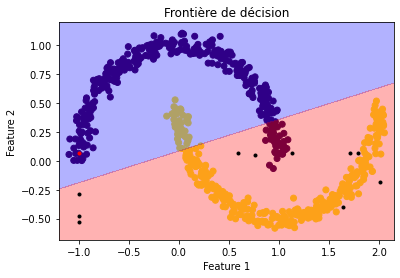

In [7]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
dice_te = dice_test(test_pd[0:1], dice_tr,10, desired_class= "opposite")
print(visualize_table(dice_te, True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

# Implémentation d'un reseau de neurones sur Pytorch 

In [26]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_t.shape[1]
model = SimpleNN(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Évaluer le modèle sur des données de test
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Epoch [100/5000], Loss: 0.3857
Epoch [200/5000], Loss: 0.2583
Epoch [300/5000], Loss: 0.2024
Epoch [400/5000], Loss: 0.1680
Epoch [500/5000], Loss: 0.1397
Epoch [600/5000], Loss: 0.1139
Epoch [700/5000], Loss: 0.0909
Epoch [800/5000], Loss: 0.0717
Epoch [900/5000], Loss: 0.0565
Epoch [1000/5000], Loss: 0.0450
Epoch [1100/5000], Loss: 0.0362
Epoch [1200/5000], Loss: 0.0295
Epoch [1300/5000], Loss: 0.0243
Epoch [1400/5000], Loss: 0.0203
Epoch [1500/5000], Loss: 0.0172
Epoch [1600/5000], Loss: 0.0147
Epoch [1700/5000], Loss: 0.0126
Epoch [1800/5000], Loss: 0.0110
Epoch [1900/5000], Loss: 0.0096
Epoch [2000/5000], Loss: 0.0084
Epoch [2100/5000], Loss: 0.0074
Epoch [2200/5000], Loss: 0.0066
Epoch [2300/5000], Loss: 0.0059
Epoch [2400/5000], Loss: 0.0053
Epoch [2500/5000], Loss: 0.0048
Epoch [2600/5000], Loss: 0.0043
Epoch [2700/5000], Loss: 0.0039
Epoch [2800/5000], Loss: 0.0035
Epoch [2900/5000], Loss: 0.0032
Epoch [3000/5000], Loss: 0.0029
Epoch [3100/5000], Loss: 0.0027
Epoch [3200/5000]

# DICE sur NN

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  9.14it/s]

Query instance (original outcome : 0)


,x0,x1,outcome
0,-0.99655,0.069412,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,1.0955387638,-0.4409981486,1.0
1,0.273318859,0.0694122207900498,1.0
2,2.0026089787,0.0694122207900498,1.0
3,1.6470488174,0.0694122207900498,1.0
4,0.0046429193,0.0694122207900498,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,2.030213,0.389698,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,-0.7870836389,1.0305126985,0.0
1,0.7865916321,0.3896978658347243,0.0
2,1.1422234682,0.6269895907,0.0
3,1.4778692196,0.3896978658347243,0.0
4,1.1030628885,1.0880918855,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,-0.675195,0.761894,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.2223719276,-0.2747629693,1.0
1,-0.5014695894,-0.55513066,1.0
2,2.0354304462,-0.0913729894,1.0
3,1.5422955998,0.1129735972,1.0
4,-0.2393987588,-0.2707403883,1.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.12072,0.985973,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.1173506947,-0.5175877111,1.0
1,0.3865153434,-0.5376298777,1.0
2,0.12072017440778085,-0.2558464655,1.0
3,1.7287093893,0.2041246061,1.0
4,-0.1601800497,-0.2150210272,1.0


None


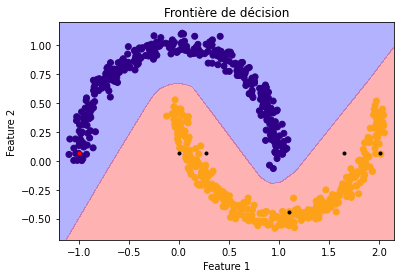

In [9]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
query = test_pd[0:4]
dice_te = dice_test(query, dice_tr, 5 , desired_class= "opposite")
print(visualize_table(dice_te,True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

# Implémentation de critères d'évaluations

**Validity**

Fraction of examples returned by a method that are actually counterfactuals

In [10]:
def prediction_class(model, X_test_t):
    with torch.no_grad():
        predicted = model(X_test_t)
        predicted_class = (predicted >= 0.5).float()
    return predicted_class

def validity(dice_te, prediction, total_cfs):
    w=0
    for i in range(len(prediction)):
        q = np.ones(total_cfs) * np.array(prediction.reshape(-1)[i])
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[:,-1].reshape(-1)
        w += np.sum(np.where(q!=sol,1,0))

    return w/(len(prediction) * total_cfs)

In [11]:
prediction = prediction_class(model,X_test_t[0:4])
print(validity(dice_te, prediction, 5))

1.0


**continuous_Proximity**

mean of feature-wise distances between the CF example and the original input

$$continuous_proximity = - \frac{1}{k}\sum_{i=1}^{k}\frac{1}{d}\sum_{p=1}^{d}\frac{\mid c^p-x^p \mid}{MAD_p}$$

In [12]:
import scipy.stats as st
def continuous_proximity(dice_te, query, X_train):
    norma =[]
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(0,len(sol)):
            for k in range(0,len(sol[j])):
                norm += np.abs(sol[j][k]-query[i][k]) / (st.median_abs_deviation(X_train, axis=0)[k])
        norma.append(-norm /(query.shape[1]*len(sol)))
    return norma

In [13]:
continuous_proximity(dice_te, X_test[0:3], X_train)

[-1.8410045128676398, -1.4578769588219471, -2.1119654701275743]

**proximité catégorielle**

Pour la proximité categorielle qui n'est pas nécessaire dans cet exemple n'ayant que des valeurs continues, on attribue 1 si la dimension est de la meme classe sinon 0.

In [14]:
def categorial_proximity(dice_te, query):
    n = query.shape[1]
    norma =[]
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(len(sol)):
            for k in range(len(sol[j])):
                d += np.sum(np.where(sol[j][k] != query[i][k], 1, 0))
            
        norma.append(1 - (d / (len(sol)*len(query))))
    return norma

**Parcimonie**

number of changes between the original input and a generated counterfactual

$$parcimonie = 1 - \frac{1}{kd}\sum_{i=1}^{k}\sum_{l=1}^{d}1_{(c_i^l-x_i^p)}$$

Plus la parcimonie est proche de 1 moins il y a eu de changement effectué dans les dimensions

In [15]:
def parcimonie(dice_te, query):
    tot = [] 
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        x = query[i].reshape(1,-1)
        d = 0
        for j in range(len(sol)):
            d += (sol[j] != x).sum()
        tot.append(1 - (d/(len(sol)*len(query))))

    return tot

In [16]:
parcimonie(dice_te, X_test[0:2])

[0.4, 0.19999999999999996]

Dice propose aussi 2 critères local feature importance et la flobal feature importance

Local feature importance scores

In [17]:
query = test_pd[0:1]
imp = dice_tr.local_feature_importance(query, total_CFs=100)
print(imp.local_importance)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:56<00:00, 56.45s/it]

[{'x0': 0.96, 'x1': 0.44}]


Global feature importance scores

In [18]:
query_instances = test_pd[0:11]
imp = dice_tr.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 11/11 [00:27<00:00,  2.46s/it]

{'x1': 0.8818181818181818, 'x0': 0.5636363636363636}


# Observation de l'evolution lors de l'évolution des paramètres

In [18]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
query = test_pd[0:10]
dice_t= []
prediction = []
validi= []
prox = []
parc = []
for i in range(2,11,2):
    dice_te = dice_test(query, dice_tr,  i , desired_class= "opposite")
    dice_t.append(dice_te)
    pred = prediction_class(model, X_test_t[0:10])
    prediction.append(pred)
    val = validity(dice_te, pred, i)
    validi.append(val)
    prox.append(continuous_proximity(dice_te, X_test[0:10], X_train))
    parc.append(parcimonie(dice_te, X_test[0:10]))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:40<00:00,  4.00s/it]


In [19]:
dice_t2= []
prediction2 = []
validi2= []
prox2 = []
parc2 = []
for i in range(2,11,2):
    dice_te2 = dice_test(query, dice_tr,  i , desired_class= "opposite", proximityweight=0.01)
    dice_t2.append(dice_te2)
    prediction2=prediction_class(model, X_test_t[0:10])
    validi2.append(validity(dice_te2, prediction2, i))
    prox2.append(continuous_proximity(dice_te2, X_test[0:10], X_train))
    parc2.append(parcimonie(dice_te2, X_test[0:10]))

100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


In [20]:
dice_t3= []
prediction3 = []
validi3= []
prox3 = []
parc3 = []
for i in range(2,11,2):
    dice_te3 = dice_test(query, dice_tr,  i , desired_class= "opposite", proximityweight=0.99)
    dice_t3.append(dice_te3)
    prediction3=prediction_class(model, X_test_t[0:10])
    validi3.append(validity(dice_te3, prediction3, i))
    prox3.append(continuous_proximity(dice_te3, X_test[0:10], X_train))
    parc3.append(parcimonie(dice_te3, X_test[0:10]))

100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


In [21]:
dice_t4= []
prediction4 = []
validi4= []
prox4 = []
parc4 = []
for i in range(2,11,2):
    dice_te4 = dice_test(query, dice_tr,  i , desired_class= "opposite", featurestovary=["x1"])
    dice_t4.append(dice_te4)
    prediction4=prediction_class(model, X_test_t[0:10])
    validi4.append(validity(dice_te4, prediction4, i))
    prox4.append(continuous_proximity(dice_te4, X_test[0:10], X_train))
    parc4.append(parcimonie(dice_te4, X_test[0:10]))

100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


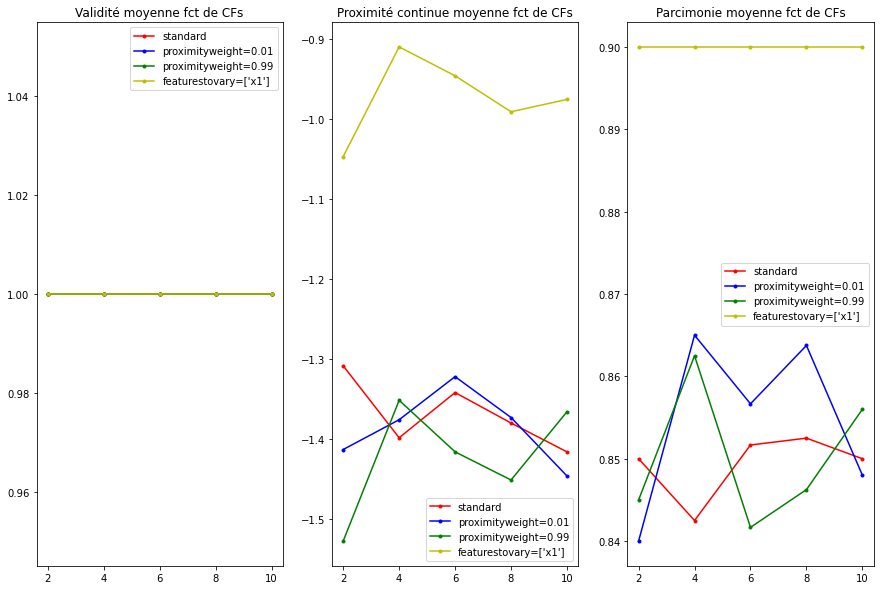

In [30]:
axe = [2,4,6,8,10]
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.plot(axe, validi, 'r.-', label="standard")
plt.plot(axe, validi2, 'b.-', label="proximityweight=0.01")
plt.plot(axe, validi3, 'g.-', label="proximityweight=0.99")
plt.plot(axe, validi4, 'y.-', label="featurestovary=['x1']")
plt.title("Validité moyenne fct de CFs")
plt.legend()
plt.subplot(1,3,2)
plt.plot(axe, [np.array(prox[i]).sum()/len(prox[i]) for i in range(len(prox))], 'r.-', label = "standard")
plt.plot(axe, [np.array(prox2[i]).sum()/len(prox2[i]) for i in range(len(prox2))], 'b.-', label="proximityweight=0.01") 
plt.plot(axe, [np.array(prox3[i]).sum()/len(prox3[i]) for i in range(len(prox3))], 'g.-' , label="proximityweight=0.99")
plt.plot(axe, [np.array(prox4[i]).sum()/len(prox4[i]) for i in range(len(prox4))], 'y.-', label="featurestovary=['x1']")
plt.title("Proximité continue moyenne fct de CFs")
plt.legend()
plt.subplot(1,3,3)
plt.plot(axe, [np.array(parc[i]).sum()/len(parc[i]) for i in range(len(parc))], 'r.-', label = "standard")
plt.plot(axe, [np.array(parc2[i]).sum()/len(parc2[i]) for i in range(len(parc2))], 'b.-', label="proximityweight=0.01")
plt.plot(axe, [np.array(parc3[i]).sum()/len(parc3[i]) for i in range(len(parc3))], 'g.-', label="proximityweight=0.99")
plt.plot(axe, [np.array(parc4[i]).sum()/len(parc4[i]) for i in range(len(parc4))], 'y.-', label="featurestovary=['x1']")
plt.title("Parcimonie moyenne fct de CFs")
plt.legend()
plt.show()

Nous avons étudié la validité, la proximité et la parcimonie en fonction du nombre de CFs créés et selon les paramètres du modele ( standard proximity_weight = 0.5 , proximity_weight =0.01, proximity_weight = 0.99 et feature pouvant varié X1 mais pas X0)
- On peut voir qu'avec desired_class='opposite' , peu importe le nombre de CFs créés, tous les modeles ont une validité de 1 ainsi il n'y a pas de de CFs de la meme classe que le point étudié.
- De manière intéressante on a l'impression que la proximité et la parcimonie sont corrélées. 
- Comme attendu, si l'on bloque une dimension, la parcimonie est constante et plus élevée que pour les autres modeles qui potentiellement peuvent avoir 1 ou 2 dimensions modifiées par CF (vs 1 seule pour le model feature_to_vary =['x1']). La proximité pour le modele feature to vary est plus élevée que les autres modèles probablement en raison de la correlation entre proximité et parcimonie.
- Plus la proximity_weight est élevée, plus on estt censé favoriser la proximité, cepedant, il semble compliqué d'étudier l'effet de ce parametre.  EN effet sur cette echantillon et ce modele, il ne semble pas y avoir de réel effet de cet hyperparametre sur la proximité et la parcimonie.

# DICE sur autres données

In [19]:
dataset =helpers.load_adult_income_dataset()
target = dataset['income']
train_dataset, test_dataset, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0,stratify=target)

# initialise DiCE
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age','hours_per_week'], outcome_name='income') 

m= dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend='TF2',func ="ohe-min-max")
exp = dice_ml.Dice(d,m)
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

2023-10-09 17:09:48.609808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 17:09:49.821548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-09 17:09:51.105028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 17:09:51.373833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-09 17:09:51.373967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,Doctorate,Married,Blue-Collar,White,Female,38,1
1,29,Private,HS-grad,Married,Blue-Collar,White,Female,97.0,1
2,29,Self-Employed,Some-college,Married,Blue-Collar,White,Female,38,1
3,29,Private,HS-grad,Married,Blue-Collar,Other,Female,97.0,1


# growing spheres : spécifier des attributs non modifiables

Nous avons modifié la fonction SL(X,a0,a1,n,indice): 
- ajout une ou des dimensions que l'on souhaite bloquer par le parametre indice
- on créé un index des dimensions que l'on a le droit de modifer
- on fait une matrice de la taille de Z à partir de X répliqué n fois
- On translate X de Z*u 
=> on genere donc les point avec la dimension vérouillée souhaitée.

In [27]:
def SL(X,a0,a1,n,indice): 
    d = X.shape[0]
    epsilon = 10**-12
    X= X.reshape(-1)
    # distribution gaussienne centrée réduite de taille n*d
    Z1 = np.random.normal(0,1,(n,d))
    #normalisé par la norme de chacun des Zi
    Z2 = Z1 / np.linalg.norm(Z1,axis=1).reshape(-1,1)
    #uniforme sur [a0**d,a1**d]
    u = np.random.uniform(a0**d,a1**d,(n,1))
    u2 = u/(u**d + epsilon)
    #projection sur l'hyperplan et translation

    dimension = []
    for i in range(d):
        dimension.append(i)
    dimension.remove(indice) 
    S = np.array((X)).reshape(1,-1).repeat(n,axis=0)
    for i in dimension:
        S[:,i] += Z2[:,i]*u[:,0]
    return S


# algorithme growing spheres generation  
def algo_GSG(X,classifier,eta,n, indice): 
    d = X.shape[0]
    # on crée une generation de points initiale entre 0 et eta
    z = SL(X,0,eta,n,indice)
    # on crée un vecteur de taille n avec la valeur de la prédiction du point X
    fx = np.ones((n)) * classifier.predict(X.reshape(1,-1))
    # on crée un vecteur de taille n avec la valeur de la prédiction de z
    prediction = classifier.predict(z)
    #
    while True:
        # si toutes les prédiction de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction == fx).all():
            break
        # sinon on réduit eta de moitié et on recrée une generation de points et leur prédiction
        else:
            eta = eta/2
            z = SL(X,0,eta,n,indice)
            prediction = classifier.predict(z)

    a0 = eta
    a1 = 2 * eta
    while True:
        # si au moins une des prédictions de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction != fx).any():
                break
        else:
            # sinon on augmente a1 de eta et on recrée une generation de points et leur prédiction
            z = SL(X,a0,a1,n,indice)
            prediction = classifier.predict(z)
            a0 = a1
            a1 = a1+eta
    
    # on récupère les indices des points de z qui ont une prédiction différente de X
    enemys= np.argwhere((prediction!=fx))
    enemy = m.inf
    # on récupère le point de z le plus proche de X parmi ceux qui ont une prédiction différente de X
    for i in enemys:
        if np.linalg.norm(z[i]-X) < enemy:
            enemy = np.linalg.norm(z[i]-X)
            ene = z[i,:]  

    return ene



# algo growing sphere feature selection
def algo_GSFS(X,classifier,enemy):
    # initialisation e_prime
    e_prime = cp.deepcopy(enemy).flatten()
    # reshape de X
    X = X.flatten()
    # liste des indices de la norme l1 de la différence entre e_prime et X triée par ordre croissant
    liste_feature = sorted(enumerate(abs(e_prime - X)), key=lambda x: x[1])
    # on ne garde que les indices des points de la liste qui ont une norme l1 non nulle
    liste_feature = [x[0] for x in liste_feature if x[1] > 0.0]
    # out est une copie de e_prime
    e_best = e_prime.copy()
    #compteur du nombre de features modifiées
    #modification = 0
    
    for k in liste_feature:
        # on modifie la k-ième feature de e_prime par celle de X
        e_second = e_best.copy()
        e_second[k] = X[k]
        # condition pour vérifier si la prédiction de e_second est différente de celle de X
        condition = classifier.predict(e_second.reshape(1, -1)) != classifier.predict(X.reshape(1,-1))
        
        if condition:
                #si condition est vérifiée on remplace e_best par e_second
                e_best[k] = e_second[k]
                #modification += 1
    
    #print("modification de %d dimensions lors du choix de e_best"%modification)

    return e_best

# algo growing sphere generation + feature selection 
def algo_GS(X,classifier,eta,n, indice):
    enemy = algo_GSG(X,classifier,eta,n, indice)
    e_best = algo_GSFS(X,classifier,enemy)
    return e_best

def affichage(x, ennemy, X_test, y_test, classifier):
    
    # Plot X
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x and son ennemy
    plt.plot(x[0], x[1], 'ro', label = 'x')
    plt.plot(ennemy[0], ennemy[1], 'r*', label = 'ennemy')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    #frontière décision 
    h = .02  
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # commentaires
    plt.legend()

    # plot.
    plt.show()

def affichage_list(x, ennemy_list, X_test, y_test, classifier):
    
    # Plot the points of X except x
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x and its ennemies
    plt.plot(x[0], x[1], 'ro', label = 'x')
    for i in range(len(ennemy_list)-1):
        plt.plot(ennemy_list[i][0], ennemy_list[i][1], 'r*')
    plt.plot(ennemy_list[-1][0], ennemy_list[-1][1], 'r*', label = 'ennemies')
    
    #frontière décision 
    h = .02  
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    # commentaires
    # Displaying the plot.


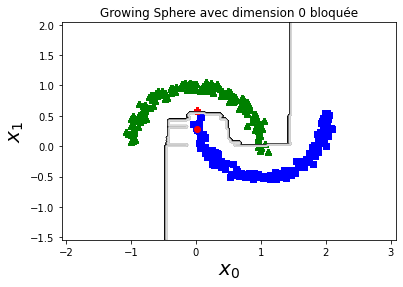

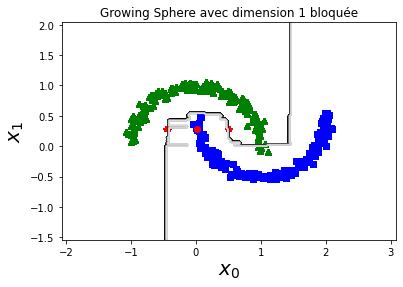

In [36]:
import math as m
clf = RandomForestClassifier(n_estimators=200)
# On entraine le classifieur
clf.fit(X_train, y_train)
# On prédit les valeurs sur le jeu de test
pred = clf.predict(X_test)

ennemy_list = []
eta = 0.5
n = 100
x = X_test[0] # on choisit un point aléatoire de X_test    
for j in range(30):
    ennemy_list.append(algo_GS(x,clf,eta,n,0))
    affichage_list(x, ennemy_list, X_test, y_test, clf)
plt.title("Growing Sphere avec dimension 0 bloquée")
plt.show()

ennemy_list = []
for j in range(30):
    ennemy_list.append(algo_GS(x,clf,eta,n,1))
    affichage_list(x, ennemy_list, X_test, y_test, clf)
plt.title("Growing Sphere avec dimension 1 bloquée")
plt.show()

** Comme on peut le voir sur le graphique suivant nous avons modifié la génération de la sphère en bloquant une dimension (possible d'en bloquer plusieurs mais pas avec cet exemple en 2D)**

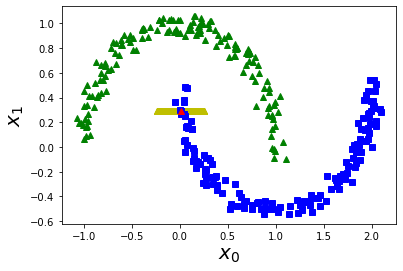

<function matplotlib.pyplot.show(close=None, block=None)>

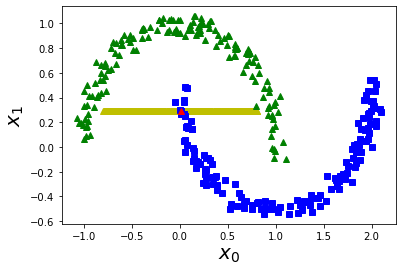

In [35]:
f = SL(x,0,0.5,1000,1)
plt.plot(f[:,0],f[:,1],'y^')
#couleur noir pour le point de test
plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs',label='classe 1')
plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')
plt.plot(X_test[0,0],X_test[0,1],'r^')

# X contains two features, x1 and x2
plt.xlabel(r"$x_0$", fontsize=20)
plt.ylabel(r"$x_1$", fontsize=20)
plt.show()
plt.close

f2 = SL(x,0.8,0.9,1000,1)
plt.plot(f2[:,0],f2[:,1],'y^')
plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs',label='classe 1')
plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')
plt.plot(X_test[0,0],X_test[0,1],'r^')

# X contains two features, x1 and x2
plt.xlabel(r"$x_0$", fontsize=20)
plt.ylabel(r"$x_1$", fontsize=20)
plt.show